# DETECCIÓN DE TRANSACCIONES FRAUDULENTAS CON TARJETAS BANCARIAS USANDO MACHINE LEARNING 

## `Masters Degree in Data Science`

# <font color='orange'>CUNEF</font>

## ASIGNACIÓN TFM 

 ### Ignacio González García-Valdés

#### -------------------

#### Target Variable 

The target variable for this dataset is the following: is_fraud

#### Assignment Objective

It is conceivable that we are dealing with a synthetic dataset designed to mimic a financial institution's card transaction dataset. Based on the available data, the primary goal of this task is to detect fraudulent transactions.

The main objective is to develop a model that can assess the probability of fraud for a given transaction. To achieve this, a thorough analysis of the data is necessary, including profiling, feature engineering, variable selection, and transformation. These steps are essential to gain insights into the underlying patterns and characteristics of fraudulent transactions.

By carefully examining the data and generating appropriate descriptors, we can create a robust model that effectively identifies and predicts the likelihood of fraud. The success of this endeavor relies on meticulous exploration, feature engineering, and comprehensive variable analysis to ensure the model's accuracy and reliability.

#### Notebook Objective

Within this document titled "01_Problem_EDA," a comprehensive exploratory analysis will be carried out on the variables that constitute the dataset. The purpose of this analysis is to gain a deeper understanding of the dataset's characteristics, uncover underlying patterns, and identify any notable trends or anomalies.

The exploratory analysis will involve examining the distribution, central tendencies, and dispersion of the variables. This will include statistical summaries, visualization techniques, and exploratory data analysis (EDA) methods to unveil insights and potential relationships among the variables.

Additionally, this document aims to identify any data quality issues, such as missing values, outliers, or inconsistencies, which may require further preprocessing steps. By conducting a thorough exploratory analysis, we can inform subsequent steps in the data analysis pipeline, including feature engineering, variable selection, and model development.

Overall, the exploratory analysis conducted in this document will serve as a foundation for understanding the dataset, formulating hypotheses, and guiding subsequent analytical and modeling tasks.

#### --------------------

#### Libraries

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import chi2_contingency
from termcolor import colored as cl
import scipy.stats as ss

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

sns.set(rc = {'figure.figsize':(30,15)})

#### Functions

In [149]:
def get_nulls(fraud_df):
    
    fraud_df_dtypes = pd.merge(fraud_df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         fraud_df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
    
    return fraud_df_dtypes.sort_values(['missing_value', 'feature_type'])

import numpy as np

def get_transactions_info(df, fraudulent_transactions, genuine_transactions):
    total_cases = len(df)
    
    fraudulent_count = len(fraudulent_transactions)
    genuine_count = len(genuine_transactions)
    fraudulent_percent = round(fraudulent_count/total_cases*100, 2)

    print('TRANSACTIONS INFORMATION IN THE DATASET')
    print('--------------------------------------------------')
    print('Total Number of Transactions are {}'.format(total_cases))
    print('Number of Genuine Transactions are {}'.format(genuine_count))
    print('Number of Fraudulent Transactions are {}'.format(fraudulent_count))
    print('Percentage of Fraud Transactions is {}%'.format(fraudulent_percent))
    print('--------------------------------------------------')

    cases = ["Genuine Cases", "Fraudulent Cases"]
    colors = ["skyblue", "deepskyblue"]

    data = [genuine_count, fraudulent_count]
    explode = (0, 0.1)
    LEFT = 0.47
    BOTTOM = 0.4
    WIDTH = 0.45
    HEIGHT = 0.45

    fig, axes = plt.subplots(figsize=(30, 10))
    ax = fig.add_axes([LEFT, BOTTOM, WIDTH, HEIGHT])

    bars = axes.bar(
        cases,
        data,
        color = colors,
        log=True  
    )

    axes.set_ylabel("Number of Cases (log scale)", fontsize=13)
    axes.set_title("Please note: Y-axis is in a logarithmic scale", pad=20)
    axes.tick_params(axis="x", labelsize=14)

    for bar in bars:
        yval = bar.get_height()
        axes.text(bar.get_x() + bar.get_width()/2, yval + 0.05, yval, ha='center', va='bottom')

    ax.pie(
        data,
        labels = cases,
        explode = explode,
        shadow = True,
        colors = colors,
        autopct = "%.2f%%",
        textprops = {"fontsize": 14},
    )
    fig.suptitle("Genuine and Fraudulent Cases of Transactions (Imbalanced Data)", fontsize = 16)
    plt.show()

    
def clean_categorical_columns(fraud_df):
    
    fraud_df_clean = fraud_df.copy()
    cat_cols = fraud_df_clean.select_dtypes(include='object').columns

   
    for col in cat_cols:
        
        if isinstance(fraud_df_clean[col][0], str):
            
            fraud_df_clean[col] = fraud_df_clean[col].apply(lambda x: x.lower().strip())

   
    unique_counts = fraud_df_clean[cat_cols].nunique().sort_values()
    print(unique_counts)

    return fraud_df_clean

def compare_variable_with_fraud(df, variable, x_label):
   
    data = df.groupby([variable, 'is_fraud']).size().unstack()
    data['Fraud Proportion'] = data[1] / (data[0] + data[1])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data.index, y=data['Fraud Proportion'], palette='Blues')
    plt.ylabel('Proportion of Frauds')
    plt.xlabel(x_label)
    plt.title(f'{x_label} vs Proportion of Frauds')
    plt.show()

def plot_transaction_amount(df, amt_threshold, bins_count):
    
    filtered_df = df[df.amt <= amt_threshold]

    
    ax = sns.histplot(x='amt', data=filtered_df, hue='is_fraud', 
                      stat='percent', multiple='dodge', 
                      common_norm=False, bins=bins_count)
    ax.set_ylabel('Proportion in Each Type')
    ax.set_xlabel('Transaction Amount (USD)')
    plt.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'])
    plt.title("Proportional Distribution of Fraudulent and Non-Fraudulent Transactions by Transaction Amount (USD)")
    plt.show()


def plot_category_fraud_percentage(df, x_var):
    data = df.groupby([x_var, 'is_fraud']).size().unstack()
    data['Fraud Proportion'] = data[1] / (data[0] + data[1])
    plt.figure(figsize=(16, 8), dpi=200)
    sns.barplot(x=data.index, y=data['Fraud Proportion'], palette='Blues')
    plt.xticks(rotation=60)
    plt.title("Fraud Proportion by Category")
    plt.show()

    
def plot_category_fraud_vs_nonfraud(df, x_var):
    data = df.groupby([x_var, 'is_fraud']).size().unstack()
    data.columns = ['Non-Fraud', 'Fraud']
    data = data.fillna(0)
    data.plot(kind='bar', stacked=False, figsize=(16, 8), colormap='coolwarm')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=60)
    plt.title('Fraud vs Non-Fraud Transactions per {}'.format(x_var))
    plt.show()

    
def extract_datetime_components(data):
    data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
    data['trans_year'] = data['trans_date_trans_time'].dt.year
    data['trans_month'] = data['trans_date_trans_time'].dt.month
    data['trans_week'] = data['trans_date_trans_time'].dt.isocalendar().week
    data['trans_dayofweek'] = data['trans_date_trans_time'].dt.day_name()
    data['trans_hour'] = data['trans_date_trans_time'].dt.hour
    return data

def calculate_customer_age(data):
    data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
    data['dob'] = pd.to_datetime(data['dob'])
    data['cust_age'] = (data['trans_date_trans_time'] - data['dob']).astype('timedelta64[Y]')
    return data

def plot_age_distribution(data):
    plt.title("Plotting Age Distribution in Relation to Fraudulent Transactions")
    trans_hour_distribution = data.groupby('is_fraud')['cust_age'].value_counts(normalize=True).rename('distribution').reset_index()
    sns.lineplot(data=trans_hour_distribution, x='cust_age', y='distribution', hue='is_fraud')
    plt.xticks(np.arange(10, 100, 5))
    plt.show()
    
def plot_fraud_percentage_by_time(df):
    time_columns = ['trans_month', 'trans_week', 'trans_dayofweek', 'trans_hour']

    for column in time_columns:
        fraud_data = df[df['is_fraud'] == 1]
        fraud_percentage = fraud_data.groupby(column).size() / len(fraud_data) * 100

        plt.figure()
        plt.plot(fraud_percentage.index, fraud_percentage.values, marker='o')
        plt.xlabel(column)
        plt.ylabel('Percentage')
        plt.title(f'Fraud Percentage by {column}')
        plt.xticks(rotation=45)
        plt.show()
        
def calculate_outliers(fraud_df):
    for column in fraud_df:
        if fraud_df[column].dtype in ['int64', 'float64']:  # only consider numeric columns
            Q1 = fraud_df[column].quantile(0.25)
            Q3 = fraud_df[column].quantile(0.75)
            IQR = Q3 - Q1
            outliers = fraud_df[(fraud_df[column] < (Q1 - 1.5 * IQR)) | (fraud_df[column] > (Q3 + 1.5 * IQR))]
            if outliers.shape[0] > 0:
                print(f"Column: {column} -> Number of Outliers: {outliers.shape[0]}, Percentage of Outliers: {100 * outliers.shape[0]/fraud_df.shape[0]:.2f}%")

def calculate_categorical_outliers(fraud_df):
    for column in fraud_df:
        if fraud_df[column].dtype == 'object':  # only consider object columns
            total_count = fraud_df[column].count()
            value_counts = fraud_df[column].value_counts()
            outliers = value_counts[value_counts < total_count*0.01]
            if outliers.sum() > 0:
                print(f"Column: {column} -> Number of Outliers: {outliers.sum()}, Percentage of Outliers: {100 * outliers.sum()/total_count:.2f}%")

def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # To obtain spearman's correlation change pearson by spearman 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar un dataset a la función')
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo)
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis', ax = ax )#cbar_kws={"shrink": .5}
    ax.set_title('Matriz de Correlación')
    plt.show()
    
def plot_top_job_fraud_percentage(df, top_n=20):
    x_var = 'job'
    data = df.groupby([x_var, 'is_fraud']).size().unstack()
    data['Fraud Proportion'] = data[1] / (data[0] + data[1])
    
    # Ordenar los trabajos por proporción de fraude y tomar los top_n trabajos
    data = data.sort_values('Fraud Proportion', ascending=False).head(top_n)
    
    plt.figure(figsize=(16, 8), dpi=200)
    sns.barplot(x=data.index, y=data['Fraud Proportion'], palette='Blues')
    plt.xticks(rotation=90)
    plt.title(f"Top {top_n} Jobs with Highest Fraud Proportion")
    plt.show()


#### Parametrisation

In [114]:
csv_train_path = '../Data/raw/fraudTrain.csv'
csv_test_path = '../Data/raw/fraudTest.csv'
csv_outpath = '../Data/Processed/fraud_dataset_EDA.csv'

#### Warnings

In [4]:
import warnings

#### --------------------

### Exploratory Data Analysis and Preprocessing

#### Data

In [119]:
train = pd.read_csv(csv_train_path)
test = pd.read_csv(csv_test_path)

We import the data, having the data divided into train and test, we are interested in unifying both dataframes into one to be able to perform the EDA and visualizations, i.e. the previous analysis. in one to be able to perform the EDA and the visualizations, i.e. the pre-analysis. 

In [120]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [121]:
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


Both csv are well imported and the input data are correct, we perform the concat to unify them. 

In [123]:
fraud_df = pd.concat([train, test], axis = 0)

In [124]:
fraud_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


We print the head values of the dataframe to see the state of the data.As we can see the data has not been previously anonymized. In order to anonymize the data, when selecting the variables, we will take into account that the variables street, first and last are not of interest to us since they are sensitive customer data. At first sight, we can see that there is a variable called unnamed:0. This variable can perfectly be the index of the previous dataframe, that when exporting the dataframe, it has not been indicated correctly and therefore it has been saved as another column, we eliminate it.

In [125]:
fraud_df = fraud_df.drop(['Unnamed: 0'], axis = 1)
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


#### Dimensions

In [117]:
shape_data = {'Número de filas': [fraud_df.shape[0]], 'Número de columnas': [fraud_df.shape[1]]}
shape_df = pd.DataFrame(shape_data)
print(shape_df)


   Número de filas  Número de columnas
0          1852394                  22


This dataset contains 1852394 observations and 22 variables. However, this number of columns is not definitive as we will need to make further adjustments to the variables and encode some of them.

#### Variable Information 

In [15]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int6

In [16]:
fraud_df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,5
1,float64,5
2,object,12


In [17]:
fraud_df.dtypes.to_frame(name='Type').T.style.set_properties(**{'background-color': 'deepskyblue'})

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
Type,object,int64,object,object,float64,object,object,object,object,object,object,int64,float64,float64,int64,object,object,object,int64,float64,float64,int64


In this dataset, we are working with 5 int variables, 12 object variables and 5 float variable. When analysing each data variable type we can see that the trans_num is an object variable, however we can see that the variable, even though it should be a int thus it is a number, it contains letters,therefore it is correctly defined. It is necessary to change the data type, or "type-cast", certain variables. Specifically, the columns 'trans_date_trans_time' and 'dob' are presently string data types, but for more efficient processing, we need to convert them into Pandas datetime objects."

It is also important to highlight, that the variable trans_date_time can be splitted into hours and minutes. Furthermore, as we can see the dataset contains certain variables, such as gender which can lead to biases within the model.We will see later, in the variables selection, which variables are selected for the model. 

#### Target Variable Analysis

In [18]:
print(fraud_df.columns)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')


In [21]:
print(fraud_df['is_fraud'].value_counts())

0    1842743
1       9651
Name: is_fraud, dtype: int64


The dataset is quite unbalanced, however this is not a problem as we can perform an over sample or under sample when doing the models.

In [128]:
fraudulent_transactions = fraud_df.query("is_fraud==1")
genuine_transactions = fraud_df.query("is_fraud==0")

TRANSACTIONS INFORMATION IN THE DATASET
--------------------------------------------------
Total Number of Transactions are 1852394
Number of Genuine Transactions are 1842743
Number of Fraudulent Transactions are 9651
Percentage of Fraud Transactions is 0.52%
--------------------------------------------------


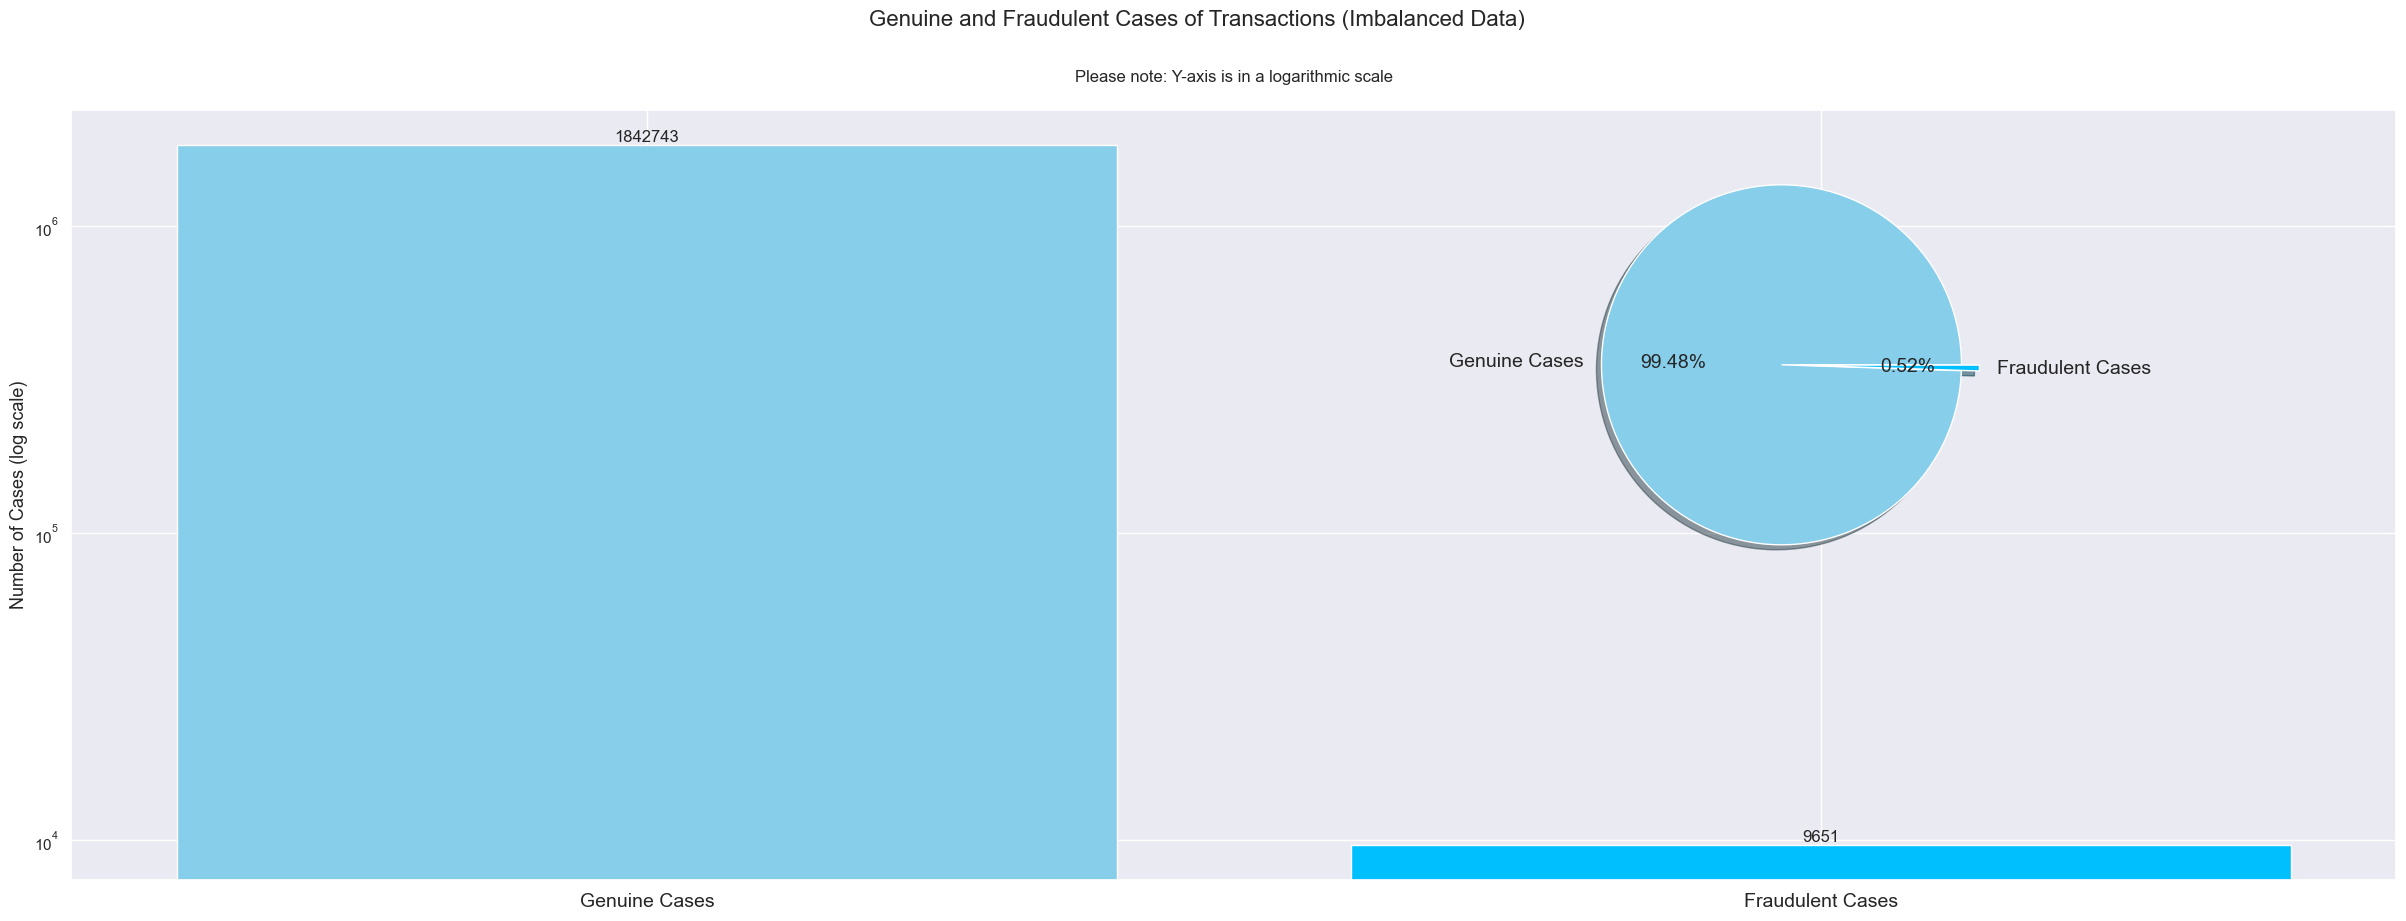

In [129]:
get_transactions_info(fraud_df, fraudulent_transactions, genuine_transactions)

With this graphical representation, we can see the distribution of the target variable. Due to the huge difference in the amount of fraudulent and genuine cases a logaritmic scale has been applied. However we can see that the fraudulent cases conform a 0,52% of the dataset. 

#### Duplicated Values

In [24]:
print("We have a total of :", fraud_df.shape[0], 'observations')

We have a total of : 1852394 observations


In [23]:
fraud_df.duplicated().value_counts()

False    1852394
dtype: int64

As we can see, there are no duplicated values within the dataset. 

#### Null values observation

In [25]:
get_nulls(fraud_df)

,index,missing_value,feature_type
2,unix_time,0,int64
6,city_pop,0,int64
9,zip,0,int64
19,cc_num,0,int64
21,is_fraud,0,int64
1,merch_lat,0,float64
7,long,0,float64
8,lat,0,float64
16,amt,0,float64
20,merch_long,0,float64


In [26]:
null = fraud_df.isna().sum()
null[null > 0].sort_values()

Series([], dtype: int64)

Furthermore, there are no nulls within the dataset. Therefore, we do not need to perform any actions over nans or duplicated entries. 

#### Outliers

##### Outlier detection for numerical variables

For the outlier detection, I will consider any value that is more than 1.5 times the interquartile range (IQR) below the first quartile or above the third quartile as an outlier, which is a commonly used definition.

In [104]:
calculate_outliers(fraud_df)

Column: cc_num -> Number of Outliers: 169771, Percentage of Outliers: 9.16%
Column: amt -> Number of Outliers: 95054, Percentage of Outliers: 5.13%
Column: lat -> Number of Outliers: 6612, Percentage of Outliers: 0.36%
Column: long -> Number of Outliers: 71026, Percentage of Outliers: 3.83%
Column: city_pop -> Number of Outliers: 346191, Percentage of Outliers: 18.69%
Column: merch_lat -> Number of Outliers: 7063, Percentage of Outliers: 0.38%
Column: merch_long -> Number of Outliers: 59972, Percentage of Outliers: 3.24%
Column: is_fraud -> Number of Outliers: 9651, Percentage of Outliers: 0.52%
Column: cust_age -> Number of Outliers: 435, Percentage of Outliers: 0.02%


In particular, there is one variables that exhibits a higher number of outliers compared to others: city_pop, with nearly 19% outliers, followed by cc_num with 9% and amt with 5%. Therefore, we can conclude that there is not a major problem within this dataset related with outliers.Outlier values can be substituted for mean, median, extreme values. After the following analysis, I have decided to leave them without replacement, since the outliers may have some value since they are located in columns like amt where the outliers may correspond to frauds. CC_num is just the credict card number so it makes sense that there are outliers and therefore there is no need to perform any action on those outliers. 


##### Outlier detection for categorical variables

For the categorical variables, we considered "outliers" the values that appear much less frequently than others. For example, we could define an outlier as a value that appears less than 1% of the time. However, this is not an optimistic aproach as the variables could have many unique values, indicating that there are many outliers in the variable. For this reason, I decided not to perform an analysis of the outliers for the categorical variables. 

### Preliminary Conclusions Drawn from Inspecting the Dataset:

- The dataframe comprises 22 columns, including the target variable
- The target variable is 'is_fraud'.
- Certain variables necessitate type-casting. For instance, 'trans_date_trans_time' and 'dob' are presently string data types that need to be converted into Pandas datetime objects.
- There are no missing values in the dataset neither duplicated entries; all columns have complete data for both the training and test datasets."

- The dataset exhibits a pronounced imbalance, indicating a class imbalance issue.
- The majority class, represented by non-fraud transactions, constitutes approximately 99.48% of the data.
- The minority class, which in this scenario is the fraudulent transactions, contributes a mere 0.52%."

### Preliminary Variables Preprocessing

#### trans_date_trans_time

This variable includes the year, month, week, day of the week and hour. By splitting this variable into different ones, we may find trends with the time of the transactions

In [140]:
fraud_df = extract_datetime_components(fraud_df)
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_week,trans_dayofweek,trans_hour
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,1,1,Tuesday,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,1,1,Tuesday,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,1,1,Tuesday,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,1,1,Tuesday,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,1,1,Tuesday,0


#### Dob

From this variable, date of birth, we can extract the age of the client that will allows us to identify trends within the age of the clients. To calculate the age of the client we will need subtract the trans_date_trans_time to the dob variable.

In [141]:
fraud_df = calculate_customer_age(fraud_df)
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_week,trans_dayofweek,trans_hour,cust_age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,1,1,Tuesday,0,30.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,1,1,Tuesday,0,40.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,1,1,Tuesday,0,56.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,1,1,Tuesday,0,51.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,1,1,Tuesday,0,32.0


The difference between the transaction date (trans_date_trans_time) and the date of birth (dob) is calculated using trans_date_trans_time - dob. Then, astype('timedelta64) is used to convert the difference into years and assign it to the cust_age column.

#### Categorical variables analysis

In [36]:
fraud_df_clean = clean_categorical_columns(fraud_df)

gender                         2
category                      14
state                         51
first                        355
last                         486
job                          497
merchant                     693
city                         906
dob                          984
street                       999
trans_date_trans_time    1819551
trans_num                1852394
dtype: int64


This functions shows the cardinality or the number of unique values for the categorical variables. This can be useful to get a quick overview of the diversity of the categorical data. For example, if a categorical column has a very high number of unique values, it might be more difficult to handle or might be less useful for modeling. In this case trans_date_trans_time and trans_num include a high number of unique values. However, trans_date_trans_time will need to be type casted. This gives us a hint of which variables can be used for the model and which ones not. 

### Individual Variables vs Fraud

#### Gender vs Fraud

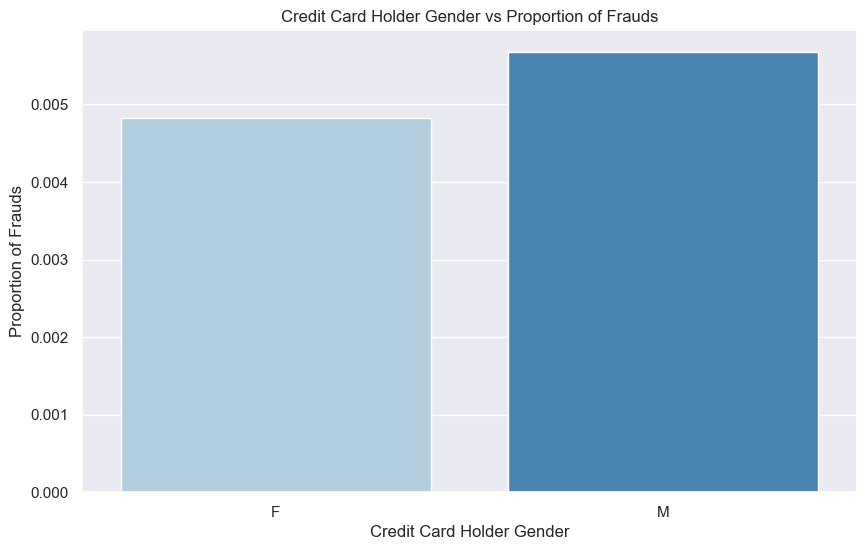

In [89]:
compare_variable_with_fraud(fraud_df, 'gender', 'Credit Card Holder Gender')

This function, creates a bar chart showing the proportion of fraud cases at each value of the selected variable. It is important to note that this representation may be more difficult to interpret than absolute counts, but it may also help to better illustrate differences between categories when there is a significant imbalance in the data set.

In this scenario, there is no apparent distinction between the two genders. The data indicates that both females and males are almost equally prone (50%) to falling victim to transaction fraud. Gender does not serve as a reliable indicator for identifying fraudulent transactions.

#### Amount vs Fraud

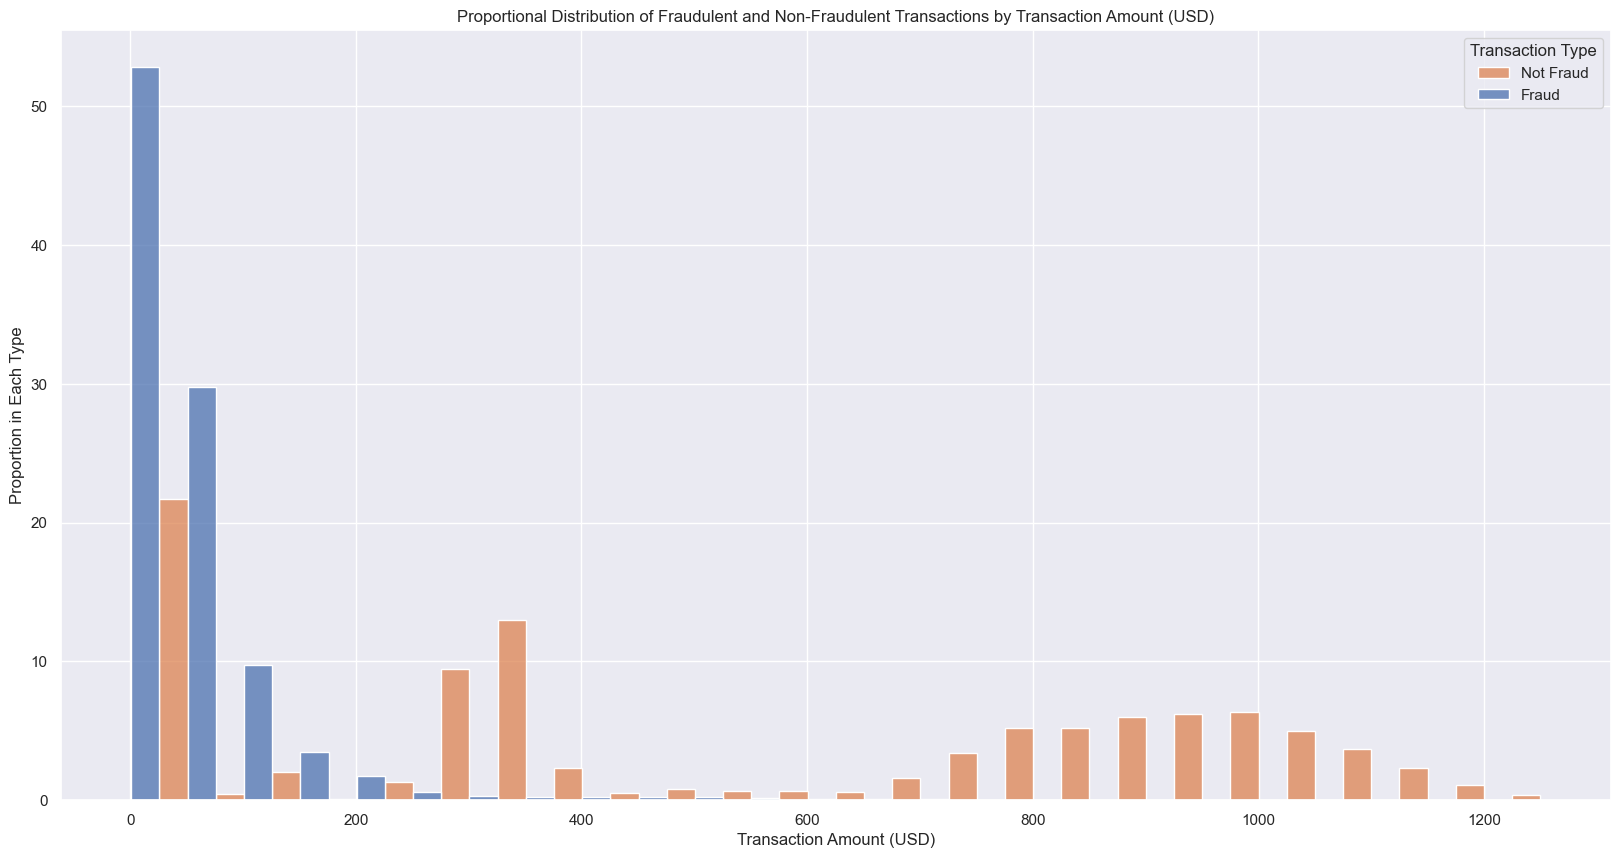

In [131]:
plot_transaction_amount(fraud_df, 1250, 25)

It is noteworthy that regular transactions typically fall within the range of 200 or less. However, fraudulent transactions exhibit a distinct trend with a peak around 300, followed by another peak within the 800 to 1000 range. This pattern is highly evident and provides valuable insights into the nature of fraudulent activities.

#### Category vs Fraud

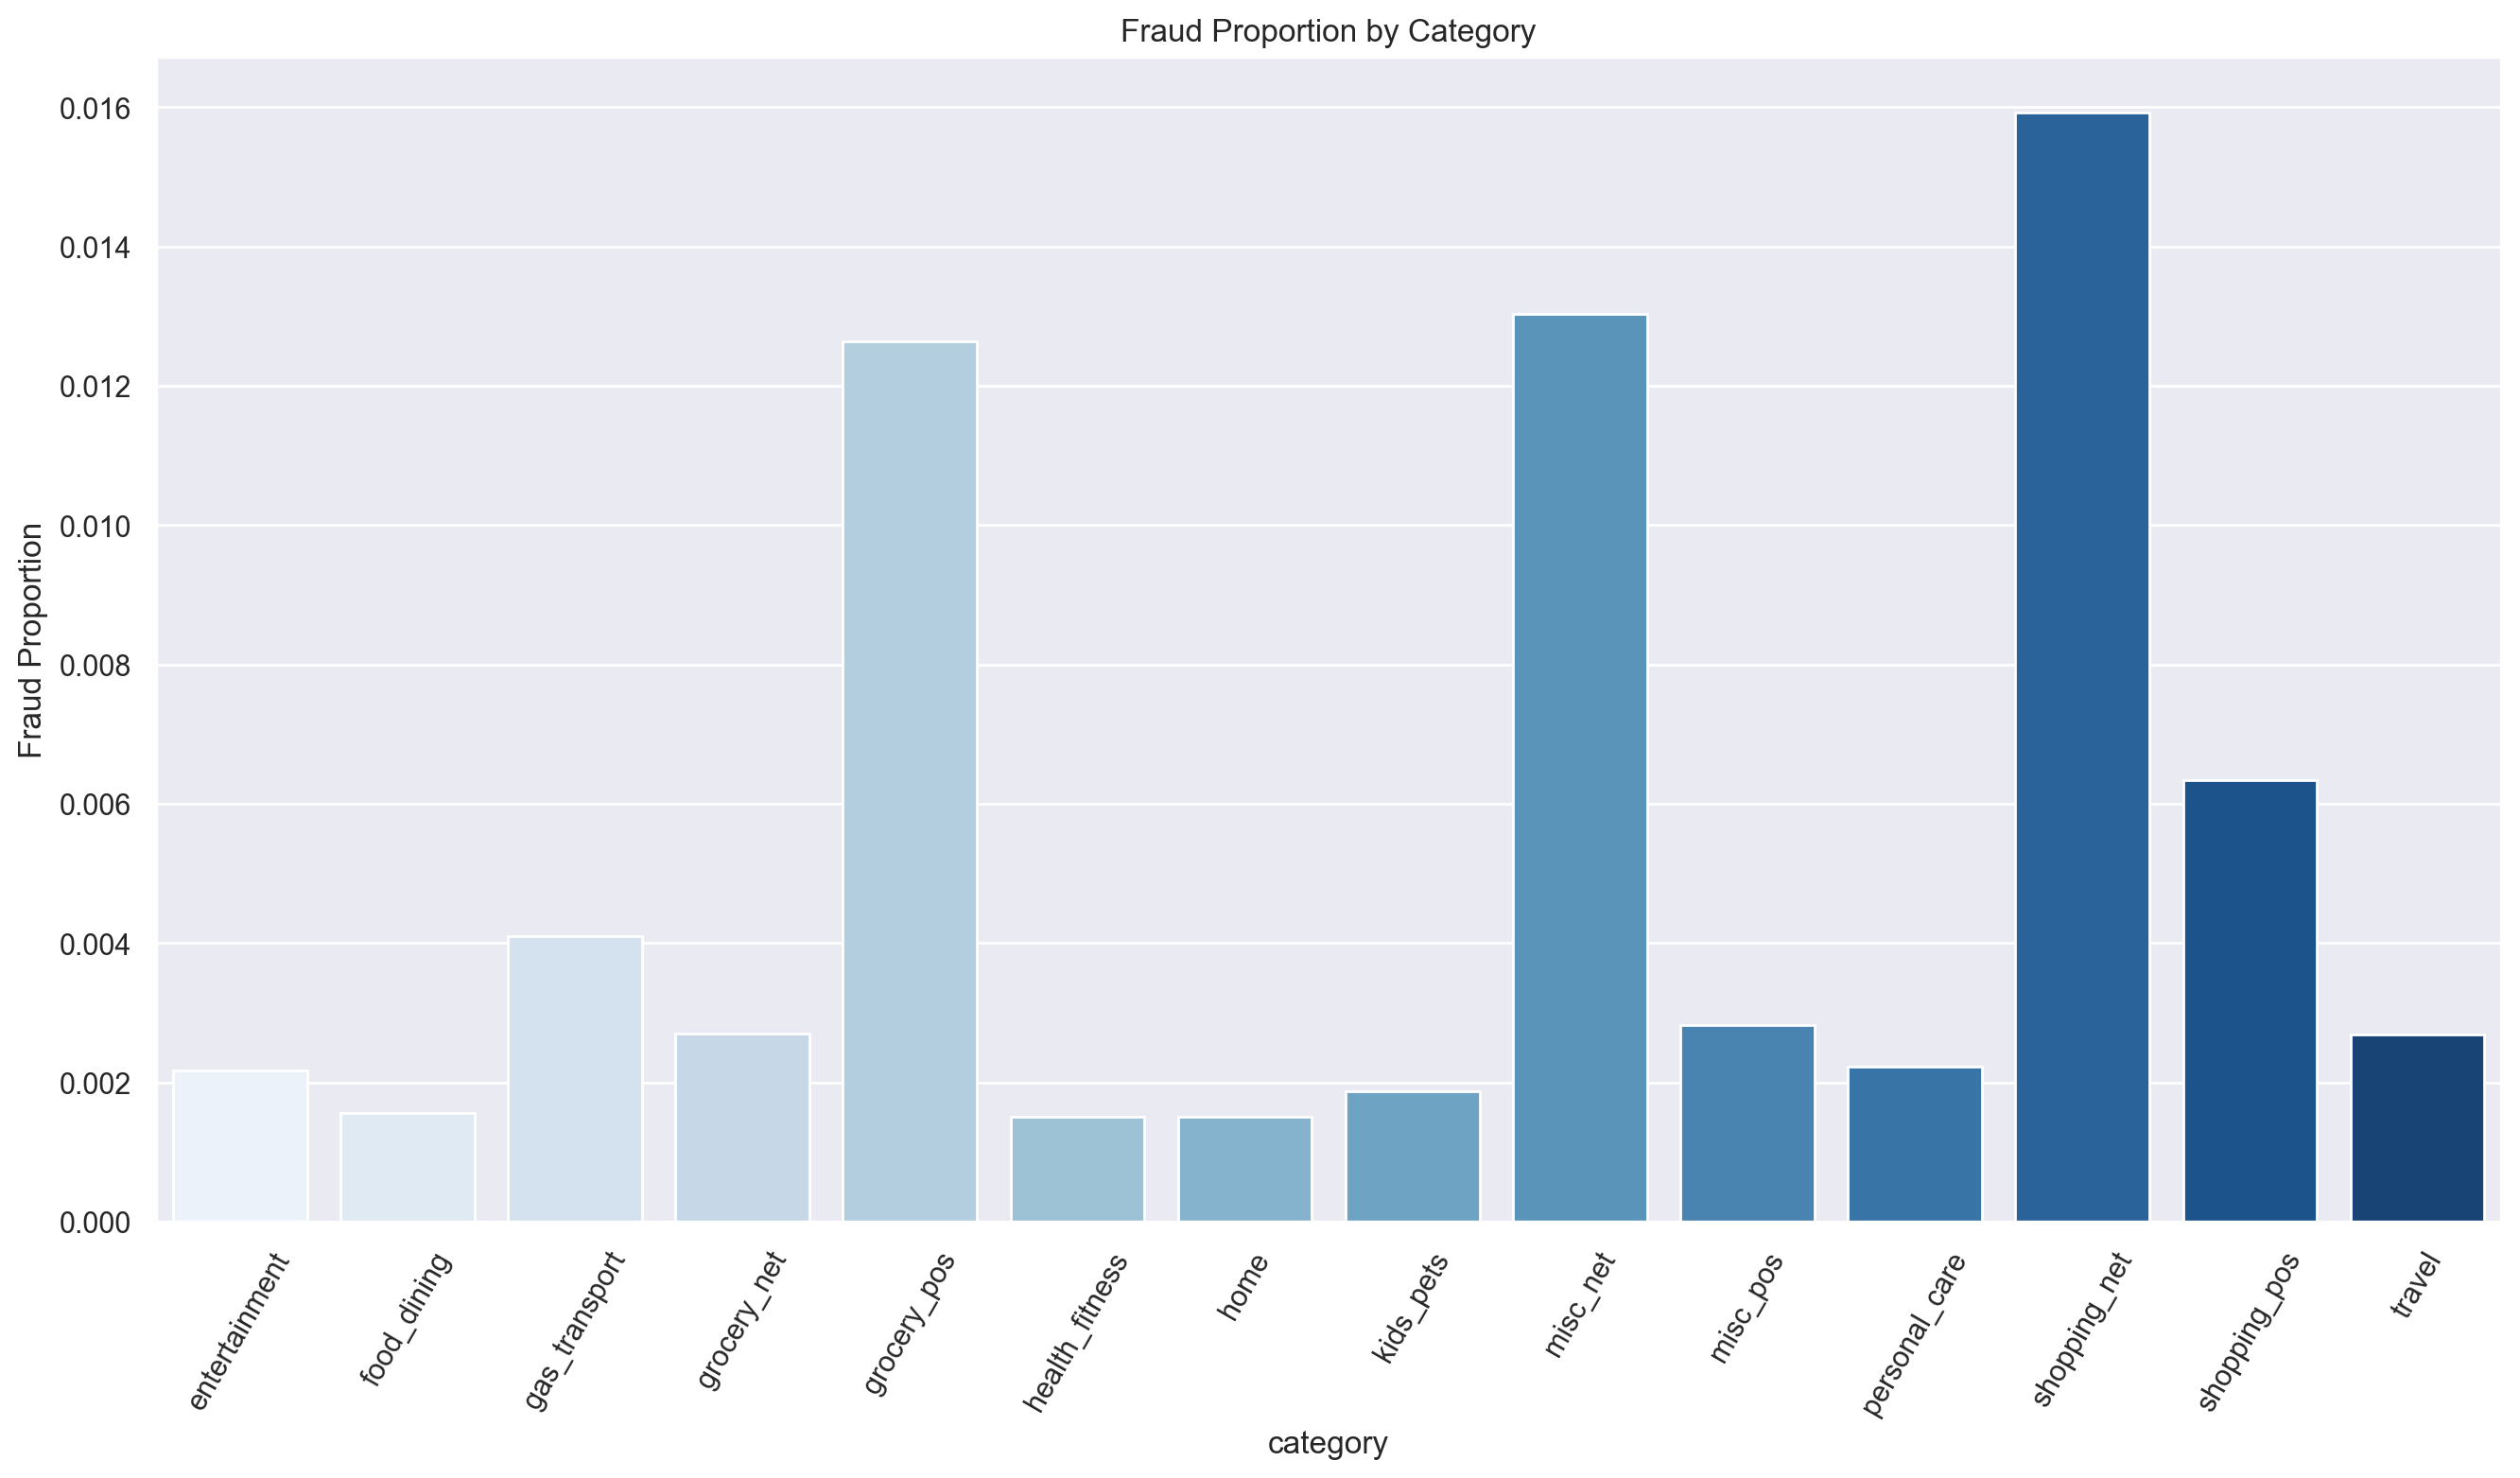

In [137]:
plot_category_fraud_percentage(fraud_df, 'category')

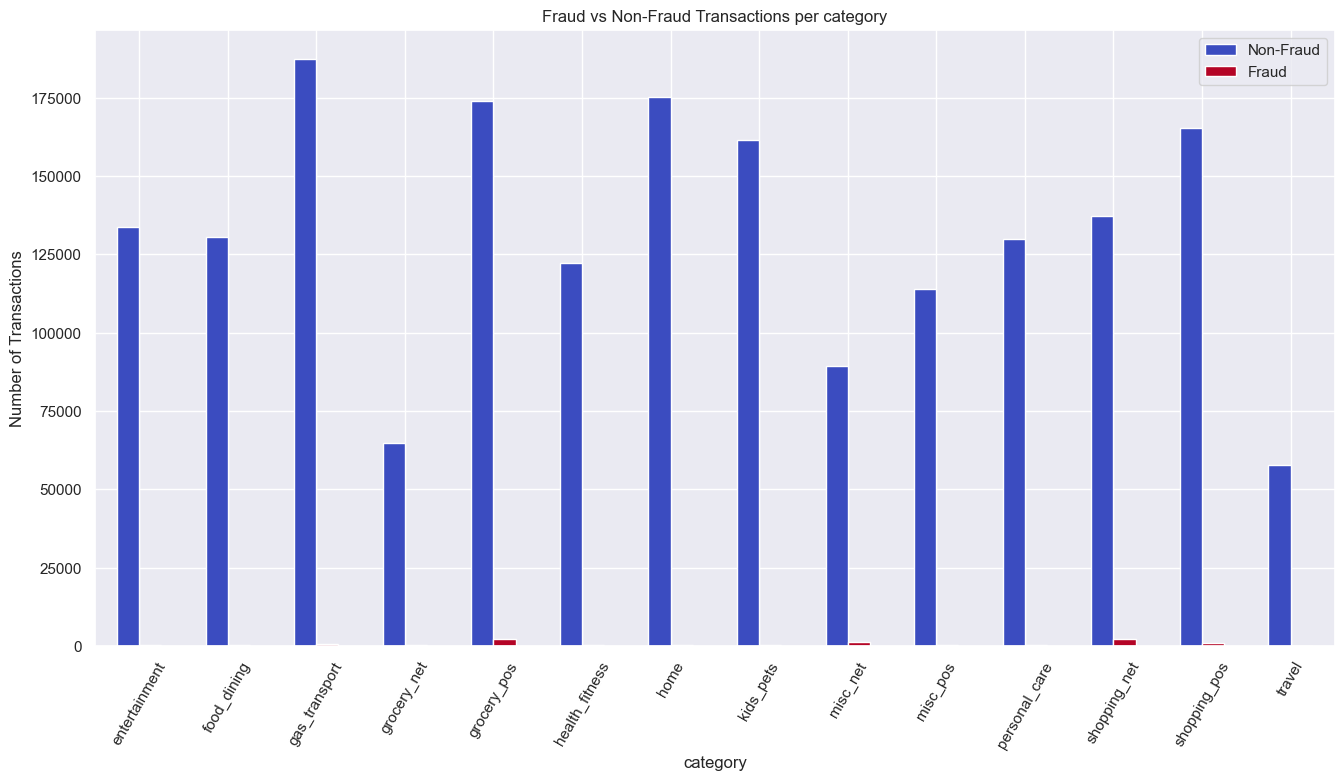

In [135]:
plot_category_fraud_vs_nonfraud(fraud_df, 'category')

This function creates a bar chart showing the proportion of fraud cases at each value of the selected variable. Please note that this representation might be more difficult to interpret than absolute counts, but it might also help to better illustrate differences between categories when there is a significant imbalance in the data set. As we can see, shipping_net, misc_net and grocery_pos are the three main categories where we have an increased number of fraudulent cases, followed by shopping_pos and gas_transport. The rest of the categories tend to have a relatively similar amount of fraud cases. 

#### Job vs Fraud

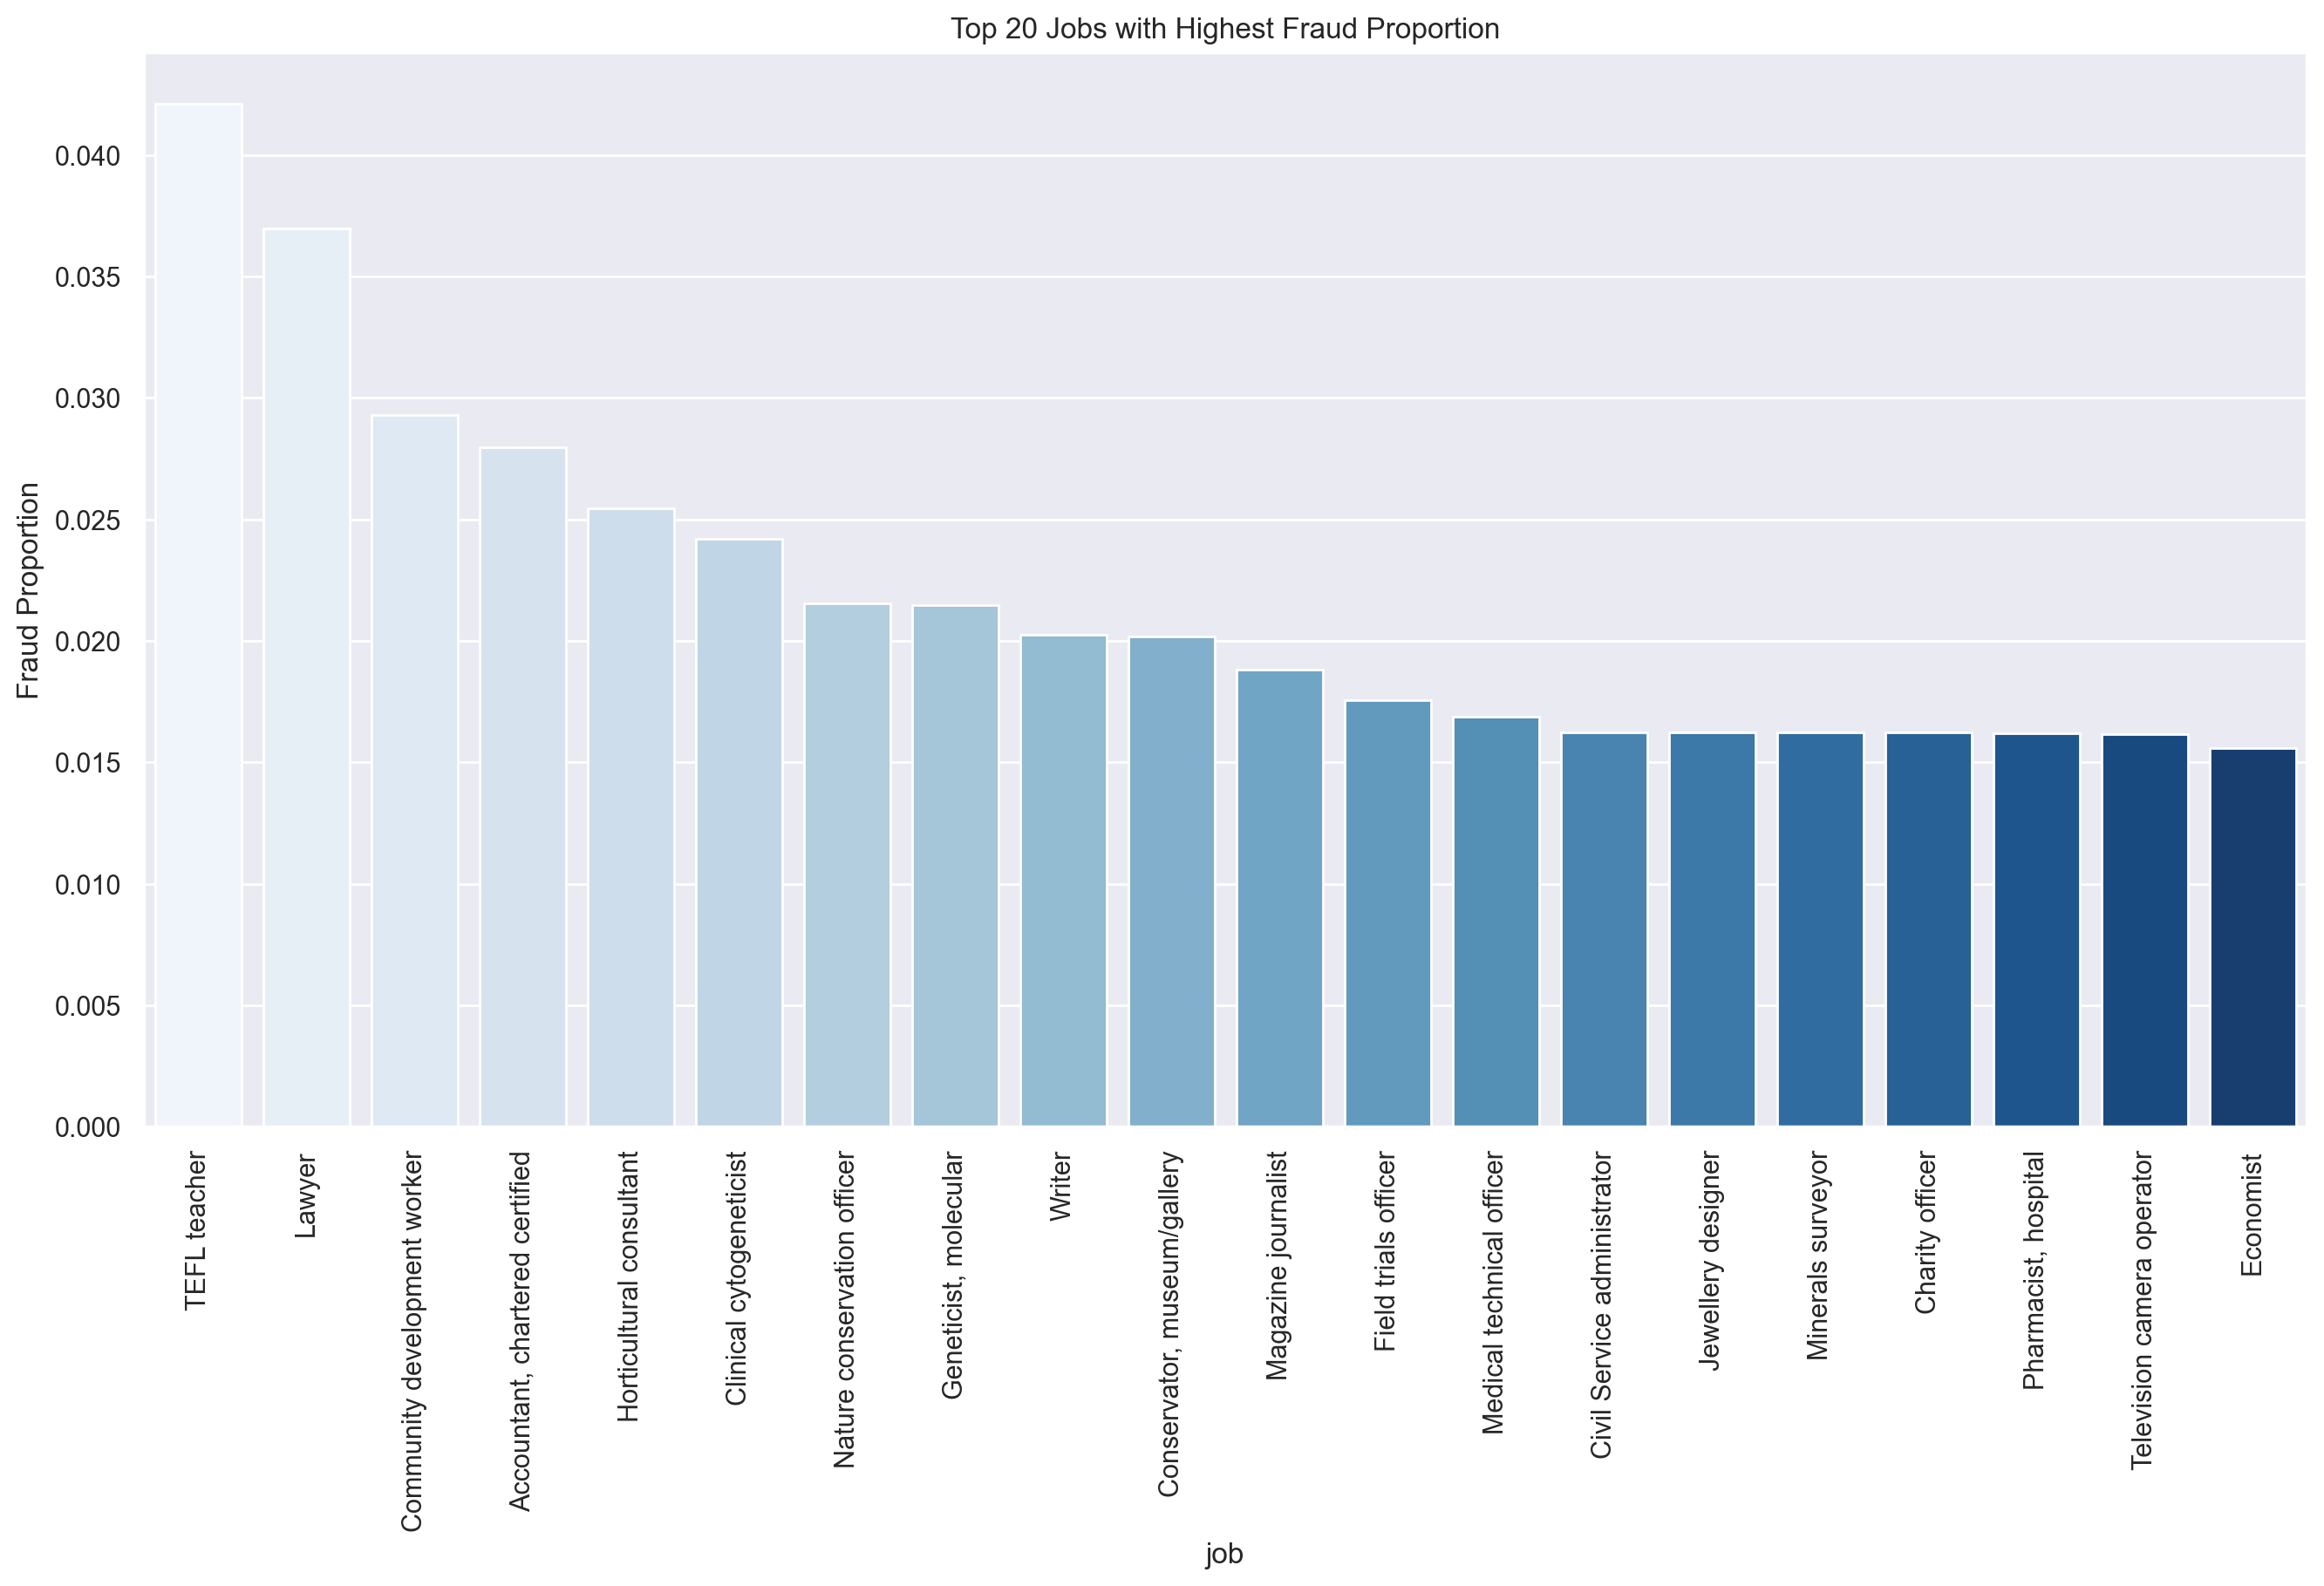

In [150]:
plot_top_job_fraud_percentage(fraud_df)

The function performs a calculation to determine the rate of fraudulent transactions corresponding to each distinct job type. This computation involves dividing the count of fraudulent transactions, signified by 'is_fraud=1', by the overall number of transactions that correspond to a particular job. This results in a unique fraud ratio for each job.

Subsequently, these job types are arranged in a descending order, starting from the job with the highest fraud ratio, down to the one with the lowest. From this ordered list, the function then picks out the 'top_n' job types that have the highest prevalence of fraud.

As clearly illustrated, the job type 'TEFL teacher' has the highest incidence of fraud, followed closely by 'lawyer'. The job type with the least fraud, among these top 20 jobs, is 'economist'. It's important to emphasize that this selection only encompasses the 20 jobs most associated with fraud. This is due to the extensive number of job types present within the dataset. Hence, within the scope of these top 20 job types, 'economist' represents the job with the lowest rate of fraud.

#### Age vs Fraud

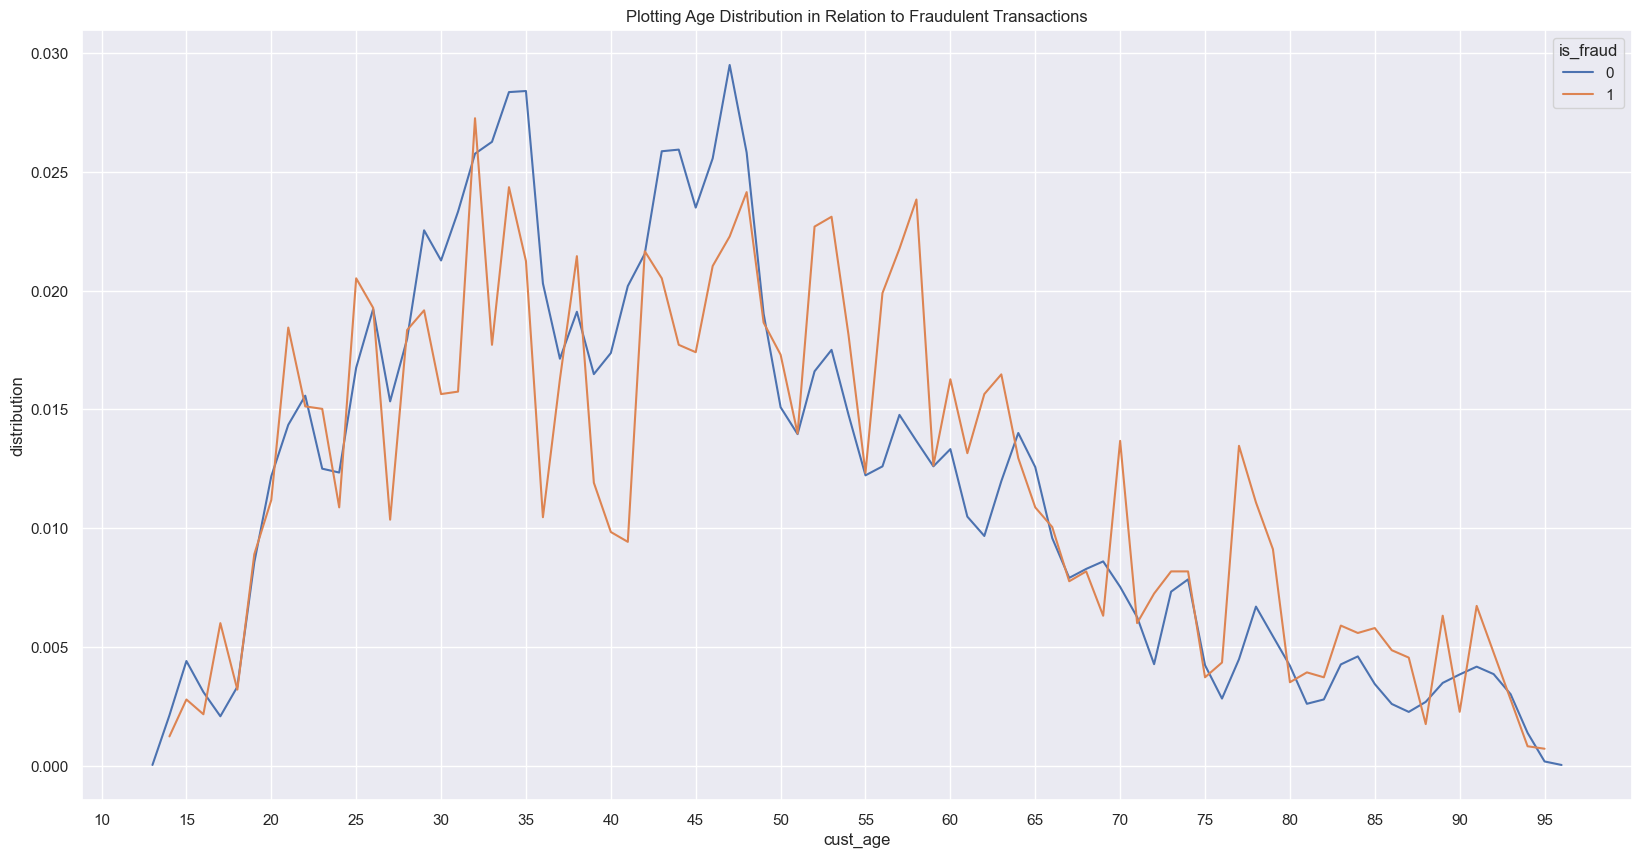

In [146]:
plot_age_distribution(fraud_df)

The majority of transactions are made by individuals in the age range of 20 to 60 years. Interestingly, fraudulent transactions are particularly concentrated among cardholders aged between 21 and 60 years. This age group appears to be significantly impacted by fraudulent activities, warranting closer attention and targeted fraud prevention measures. We can observe a notable increase in fraudulent transactions from the age of 20 onwards and a subsequent decrease from the age of 65 onwards.

#### Fraud by Time units

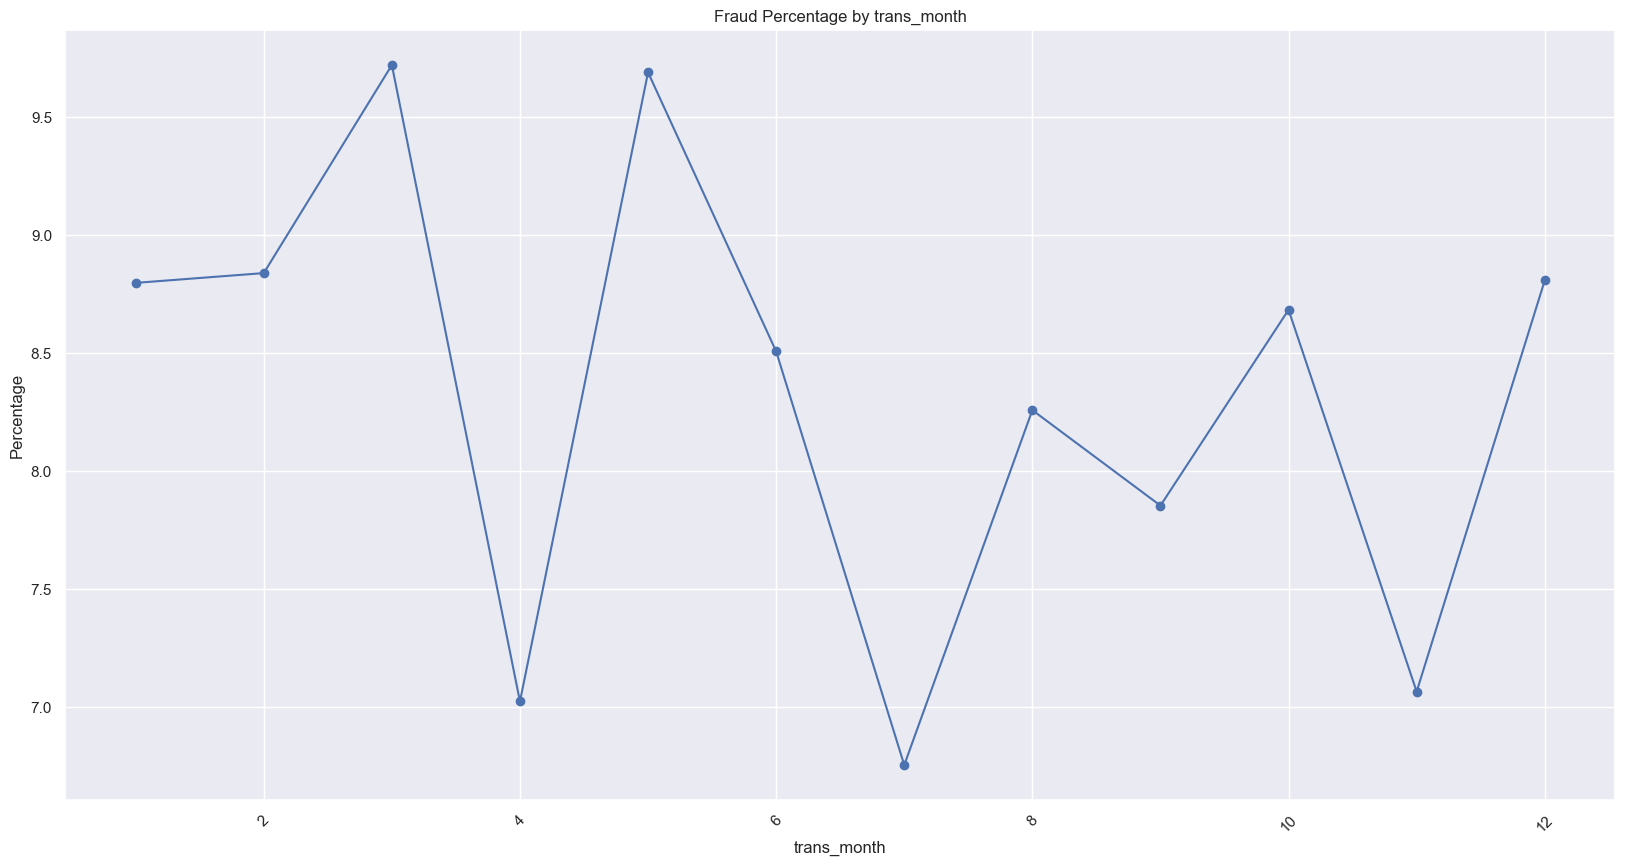

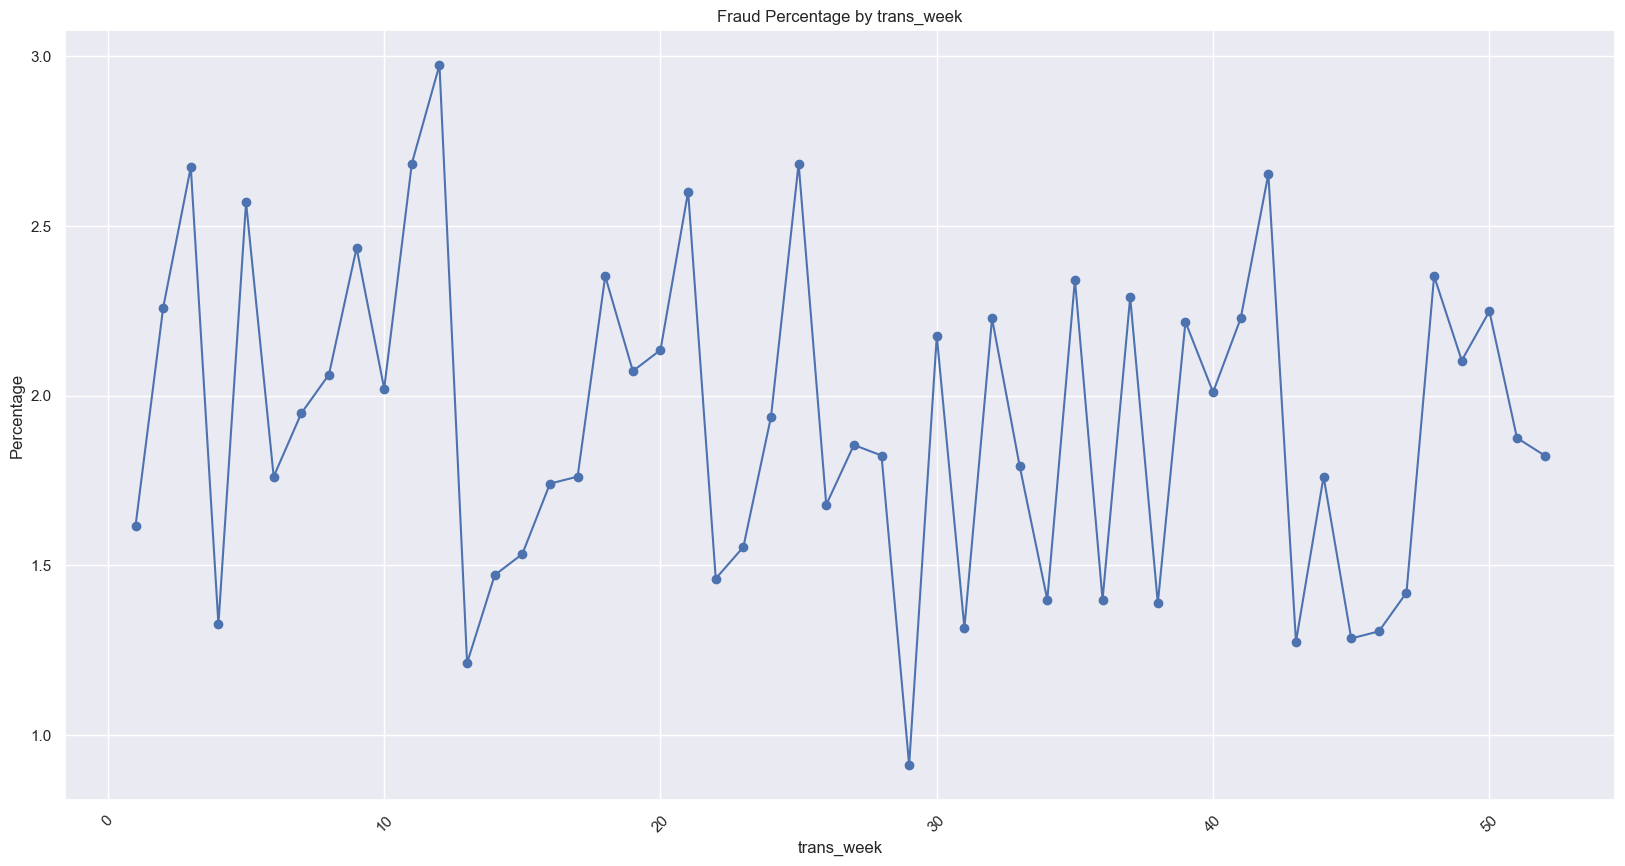

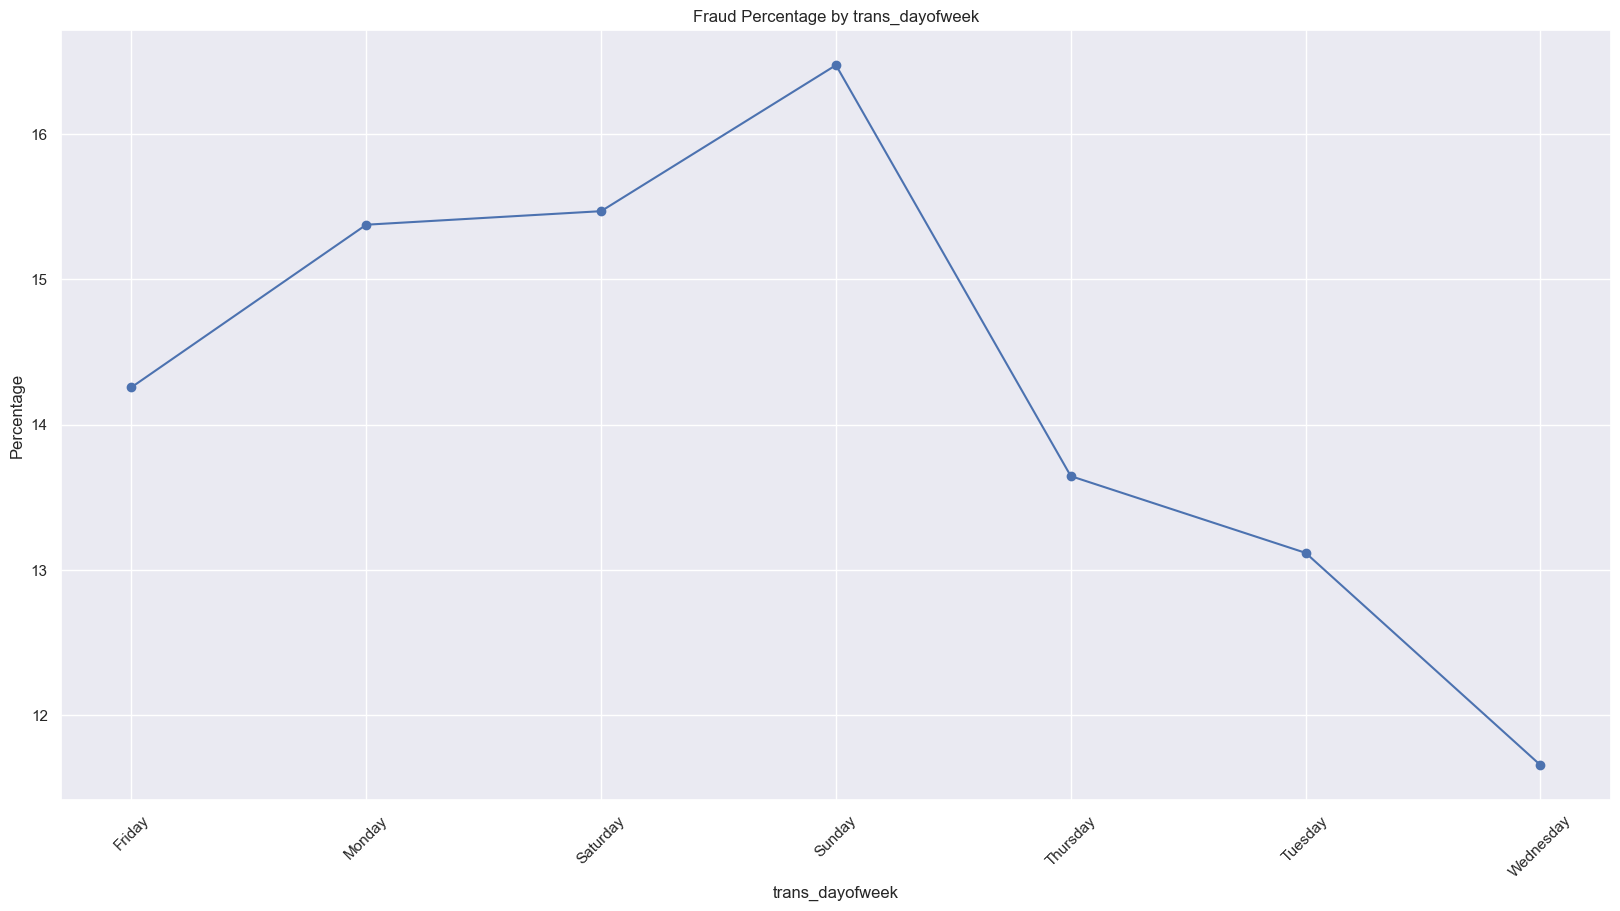

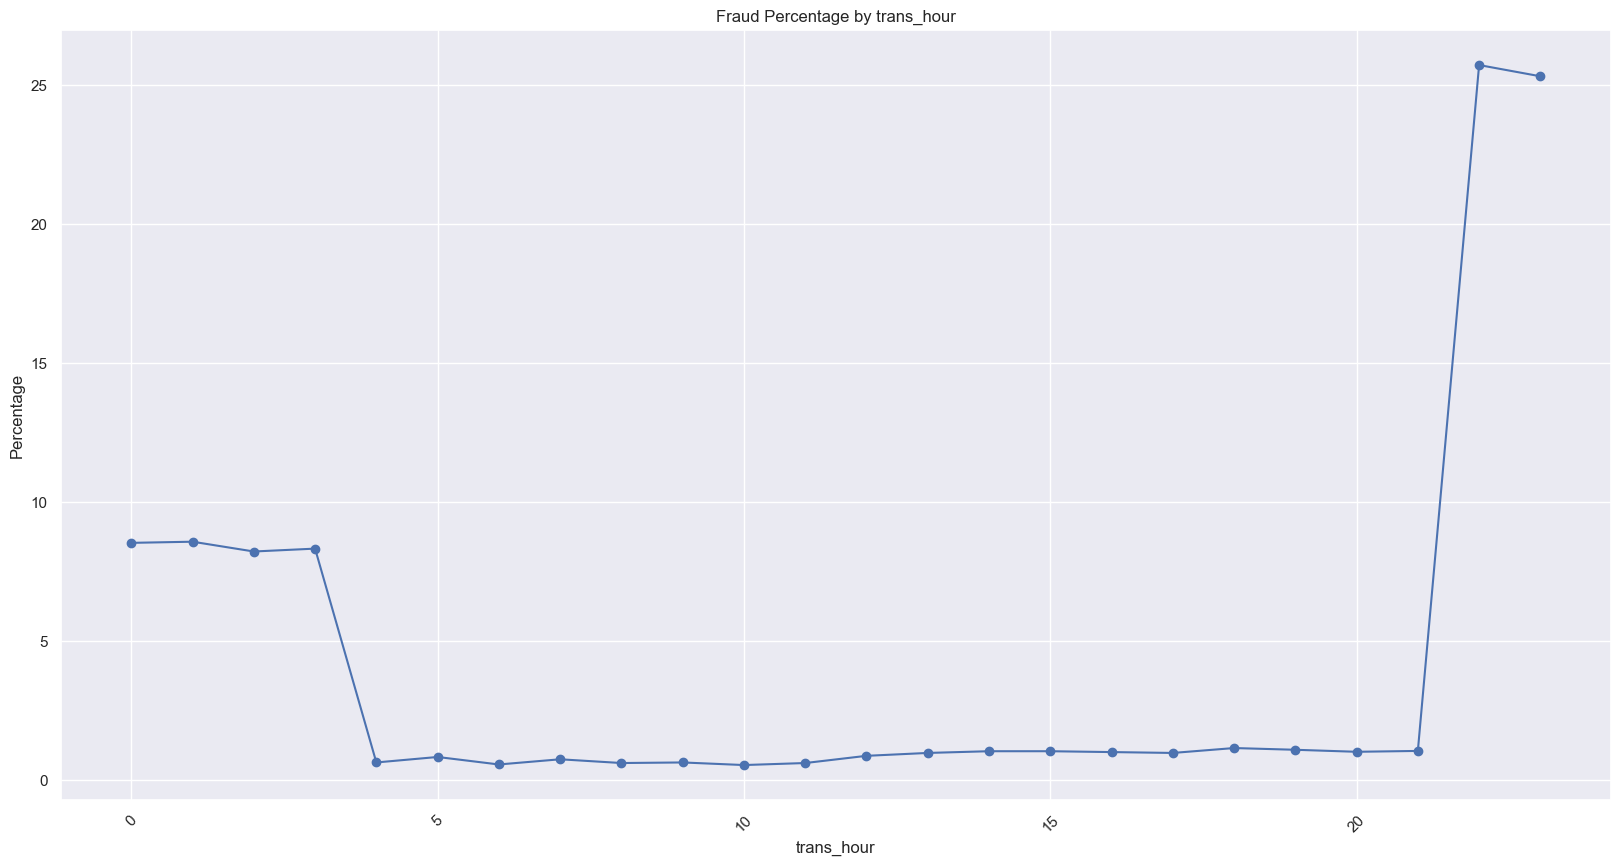

In [102]:
plot_fraud_percentage_by_time(fraud_df)

This function generates a separate graph for each time unit in the dataframe. Each graph will show the percentage of fraudulent transactions as a function of that specific time unit. 

Trans_month: Regarding the month of the transaction we can see that most fraudulent cases take place in the first 3 months of the year and the fifth month. 

Trans_week: We can identify a clear pattern. However, evidentlly it follows a similiar trend as the month variable. 

Trams_dayofweek: We can see that fraudulent transactions tend to increase from friday to monday(weekends) and decrease during the week.

Trans_hour: It seems that fraudulent cases occuring during the first 4 hours of the day, remaining constant and heavly during the last hours of the day, ocurring at midnight. Fraud Transactions are majorly taking place between 21st hour - 04 hour. To put it differently, fraudulent transactions tend to occur during the late-night hours when genuine cardholders are typically asleep and unlikely to receive transaction notifications. This timing provides an advantage to fraudsters as they exploit the reduced likelihood of immediate detection or response from cardholders. This highlights the importance of implementing proactive fraud prevention measures that can operate effectively even when cardholders are not actively monitoring their transactions. By doing so, the ability to detect and mitigate fraud during these vulnerable hours can be significantly enhanced, providing a more secure environment for cardholders.

In [108]:
list_var_continuous = ["cc_num", "amt", "lat", "long", "city_pop", "merch_lat", "merch_long", "cust_age"]

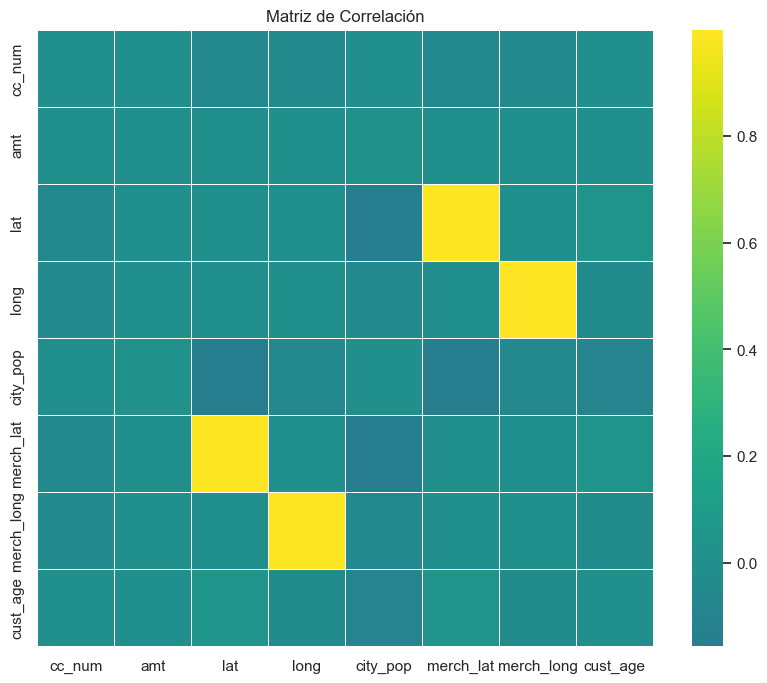

In [111]:
get_corr_matrix(dataset = fraud_df[list_var_continuous], metodo='pearson')

As we can see we have a high correlation between latitude and longitude and the respective merch latitude and longitude.

#### DROP unnecessary columns

In [112]:
fraud_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_month,trans_dayofweek,trans_hour,trans_year,trans_week,cust_age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,1,Tuesday,0,2019,1,30.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,1,Tuesday,0,2019,1,40.0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,1,Tuesday,0,2019,1,56.0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1,Tuesday,0,2019,1,51.0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,1,Tuesday,0,2019,1,32.0


In [113]:
drop_cols = ['trans_date_trans_time','first','last','gender','street', 'dob']

fraud_df.drop(drop_cols, axis = 1, inplace = True)
fraud_df.head()

,cc_num,merchant,category,amt,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_month,trans_dayofweek,trans_hour,trans_year,trans_week,cust_age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,1,Tuesday,0,2019,1,30.0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,1,Tuesday,0,2019,1,40.0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,1,Tuesday,0,2019,1,56.0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1,Tuesday,0,2019,1,51.0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,1,Tuesday,0,2019,1,32.0


We have eliminated variables such as first last and street as we want the dataset to be anonymized. Dob and trans date trans time have been processed into new columns, therefore we do no longer need these variables. Finally, gender may lead to biases within our model. 

#### CSV export

In [116]:
fraud_df.to_csv(csv_outpath, index = False)